
<a id='general-packages'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# General Purpose Packages

## Contents

- [General Purpose Packages](#General-Purpose-Packages)  
  - [Overview](#Overview)  
  - [Numerical Integration](#Numerical-Integration)  
  - [Interpolation](#Interpolation)  
  - [Linear Algebra](#Linear-Algebra)  
  - [General Tools](#General-Tools)  

## Overview

Julia has both a large number of useful, well written libraries and many incomplete poorly maintained proofs of concept

A major advantage of Julia libraries is that, because Julia itself is sufficiently fast, there is less need to mix in low level languages like C and Fortran

As a result, most Julia libraries are written exclusively in Julia

Not only does this make the libraries more portable, it makes them much easier to dive into, read, learn from and modify

In this lecture we introduce a few of the Julia libraries that we’ve found particularly useful for quantitative work in economics

Also see [data and statistical packages](https://julia.quantecon.org/data_statistical_packages.html) and [optimization, solver, and related packages](https://julia.quantecon.org/optimization_solver_packages.html) for more domain specific packages

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.4.0")

In [2]:
using LinearAlgebra, Statistics
using QuantEcon, QuadGK, FastGaussQuadrature, Distributions, Expectations
using Interpolations, Plots, LaTeXStrings, ProgressMeter

## Numerical Integration

Many applications require directly calculating a numerical derivative and calculating expectations

### Adaptive Quadrature

A high accuracy solution for calculating numerical integrals is [QuadGK](https://github.com/JuliaMath/QuadGK.jl)

In [3]:
using QuadGK
@show value, tol = quadgk(cos, -2π, 2π);

(value, tol) = quadgk(cos, -2π, 2π) = (-1.5474478810961125e-14, 5.7846097329025695e-24)


This is an adaptive Gauss-Kronrod integration technique that’s relatively accurate for smooth functions

However, its adaptive implementation makes it slow and not well suited to inner loops

### Gaussian Quadrature

Alternatively, many integrals can be done efficiently with (non-adaptive) [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)

For example, using [FastGaussQuadrature.jl](https://github.com/ajt60gaibb/FastGaussQuadrature.jl)

In [4]:
using FastGaussQuadrature
x, w = gausslegendre( 100_000 ); # i.e. find 100,000 nodes

# integrates f(x) = x^2 from -1 to 1
f(x) = x^2
@show w ⋅ f.(x); # calculate integral

w ⋅ f.(x) = 0.6666666666666667


The only problem with the `FastGaussQuadrature` package is that you will need to deal with affine transformations to the non-default domains yourself

Alternatively, `QuantEcon.jl` has routines for Gaussian quadrature that translate the domains

In [5]:
using QuantEcon

x, w = qnwlege(65, -2π, 2π);
@show w ⋅ cos.(x); # i.e. on [-2π, 2π] domain

w ⋅ cos.(x) = -3.0064051806277455e-15


### Expectations

If the calculations of the numerical integral is simply for calculating mathematical expectations of a particular distribution, then [Expectations.jl](https://github.com/QuantEcon/Expectations.jl) provides a convenient interface

Under the hood, it is finding the appropriate Gaussian quadrature scheme for the distribution using `FastGaussQuadrature`

In [6]:
using Distributions, Expectations
dist = Normal()
E = expectation(dist)
f(x) = x
@show E(f) #i.e. identity

# Or using as a linear operator
f(x) = x^2
x = nodes(E)
w = weights(E)
E * f.(x) == f.(x) ⋅ w

E(f) = -6.991310601309959e-18


true

## Interpolation

In economics we often wish to interpolate discrete data (i.e., build continuous functions that join discrete sequences of points)

The package we usually turn to for this purpose is [Interpolations.jl](https://github.com/JuliaMath/Interpolations.jl)

There are a variety of options, but we will only demonstrate the convenient notations

### Univariate with a Regular Grid

Let’s start with the univariate case

We begin by creating some data points, using a sine function

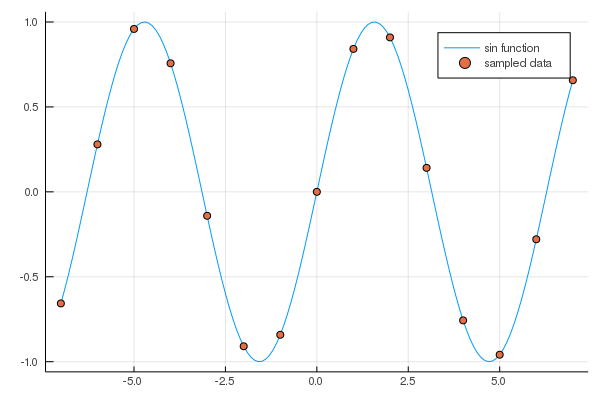

In [7]:
using Interpolations
using Plots
gr(fmt=:png);

x = -7:7 # x points, coase grid
y = sin.(x) # corresponding y points

xf = -7:0.1:7        # fine grid
plot(xf, sin.(xf), label = "sin function")
scatter!(x, y, label = "sampled data", markersize = 4)

To implement linear and cubic [spline](https://en.wikipedia.org/wiki/Spline_%28mathematics%29) interpolation

li(0.3) = 0.25244129544236954


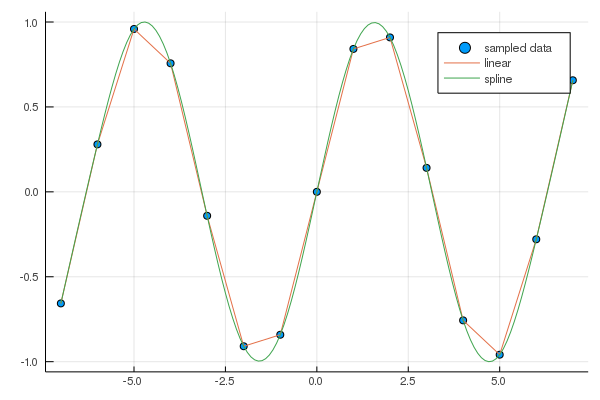

In [8]:
li = LinearInterpolation(x, y)
li_spline = CubicSplineInterpolation(x, y)

@show li(0.3) # evaluate at a single point

scatter(x, y, label = "sampled data", markersize = 4)
plot!(xf, li.(xf), label = "linear")
plot!(xf, li_spline.(xf), label = "spline")

### Univariate with Irregular Grid

In the above, the `LinearInterpolation` function uses a specialized function
for regular grids since `x` is a `Range` type

For an arbitrary, irregular grid

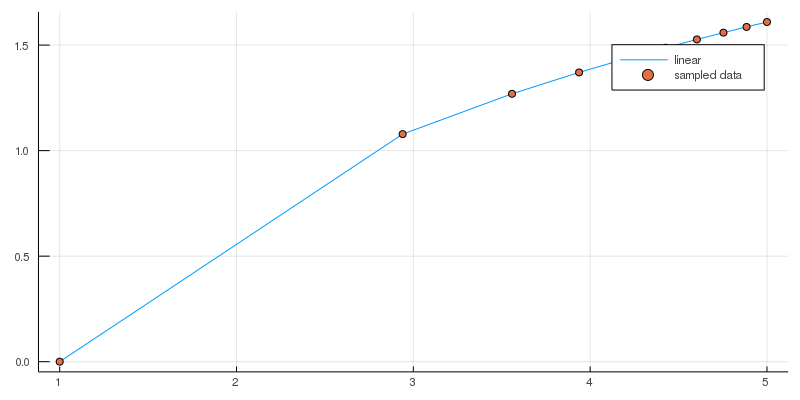

In [9]:
x = log.(range(1, exp(4), length = 10)) .+ 1  # uneven grid
y = log.(x) # corresponding y points

interp = LinearInterpolation(x, y)

xf = log.(range(1,  exp(4), length = 100)) .+ 1 # finer grid

plot(xf, interp.(xf), label = "linear")
scatter!(x, y, label = "sampled data", markersize = 4, size = (800, 400))

At this point, `Interpolations.jl` does not have support for cubic splines with irregular grids, but there are plenty of other packages that do (e.g. [Dierckx.jl](https://github.com/kbarbary/Dierckx.jl)  and [GridInterpolations.jl](https://github.com/sisl/GridInterpolations.jl))

### Multivariate Interpolation

Interpolating a regular multivariate function uses the same function

In [10]:
f(x,y) = log(x+y)
xs = 1:0.2:5
ys = 2:0.1:5
A = [f(x,y) for x in xs, y in ys]

# linear interpolation
interp_linear = LinearInterpolation((xs, ys), A)
@show interp_linear(3, 2) # exactly log(3 + 2)
@show interp_linear(3.1, 2.1) # approximately log(3.1 + 2.1)

# cubic spline interpolation
interp_cubic = CubicSplineInterpolation((xs, ys), A)
@show interp_cubic(3, 2) # exactly log(3 + 2)
@show interp_cubic(3.1, 2.1) # approximately log(3.1 + 2.1);

interp_linear(3, 2) = 1.6094379124341003
interp_linear(3.1, 2.1) = 1.6484736801441782


interp_cubic(3, 2) = 1.6094379124341
interp_cubic(3.1, 2.1) = 1.6486586594237707


See [Interpolations.jl documentation](https://github.com/JuliaMath/Interpolations.jl#convenience-notation) for more details on options and settings

## Linear Algebra

### Standard Library

The standard library contains many useful routines for linear algebra, in
addition to standard functions such as `det()`, `inv()`, `factorize()`, etc.

Routines are available for

- Cholesky factorization  
- LU decomposition  
- Singular value decomposition,  
- Schur factorization, etc.  


See [here](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/) for further details

## General Tools

### LaTeXStrings.jl

When you need to properly escape latex code (e.g. for equation labels), use [LaTeXStrings.jl](https://github.com/stevengj/LaTeXStrings.jl)

In [11]:
using LaTeXStrings
L"an equation: $1 + \alpha^2$"

L"an equation: $1 + \alpha^2$"

### ProgressMeter.jl

For long-running operations, you can use the [ProgressMeter.jl](https://github.com/timholy/ProgressMeter.jl) package

To use the package, you simply put a macro in front of `for` loops, etc.

From the documentation

In [12]:
using ProgressMeter

@showprogress 1 "Computing..." for i in 1:50
    sleep(0.1) # some computation....
end

Computing... 12%|████▋                                  |  ETA: 0:00:07

Computing... 36%|██████████████                         |  ETA: 0:00:04

Computing... 56%|█████████████████████▉                 |  ETA: 0:00:03

Computing... 76%|█████████████████████████████▋         |  ETA: 0:00:01

Computing... 96%|█████████████████████████████████████▌ |  ETA: 0:00:00

Computing...100%|███████████████████████████████████████| Time: 0:00:05
